In [3]:
import pandas as pd
# 데이터 로드
file_path = 'C:\\Users\\Admin\\Documents\\GitHub\\sg_2cha\\sy\\data\\eng_E-commerce_ref.csv'  # 파일 경로를 지정하세요
data = pd.read_csv(file_path)

# 데이터 구조 확인
print("데이터셋 구조:")
print(data.info())

# 데이터 샘플 확인
print("\n데이터 샘플:")
print(data.head())

# 데이터의 크기 확인
print("\n데이터 크기 (행, 열):", data.shape)


데이터셋 구조:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5379 entries, 0 to 5378
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5379 non-null   int64  
 1   Churn                        5379 non-null   int64  
 2   Tenure                       5379 non-null   float64
 3   PreferredLoginDevice         5379 non-null   object 
 4   CityTier                     5379 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5379 non-null   object 
 7   Gender                       5379 non-null   object 
 8   HourSpendOnApp               5379 non-null   float64
 9   NumberOfDeviceRegistered     5379 non-null   float64
 10  PreferedOrderCat             5379 non-null   object 
 11  SatisfactionScore            5379 non-null   int64  
 12  MaritalStatus                5379 non-null   object 
 13  NumberOfA

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 705, number of negative: 3598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 4303, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163839 -> initscore=-1.629936
[LightGBM] [Info] Start training from score -1.629936

=== Model Performance ===
Confusion Matrix:
 [[911   6]
 [ 21 138]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       917
           1       0.96      0.87      0.91       159

    accuracy                 

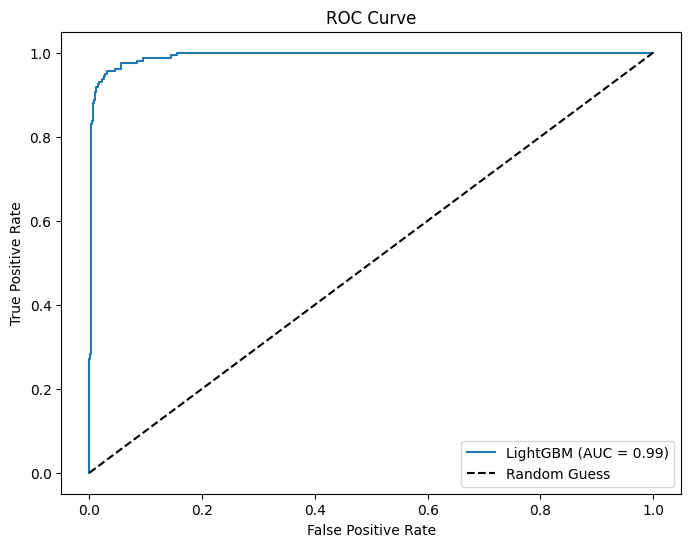

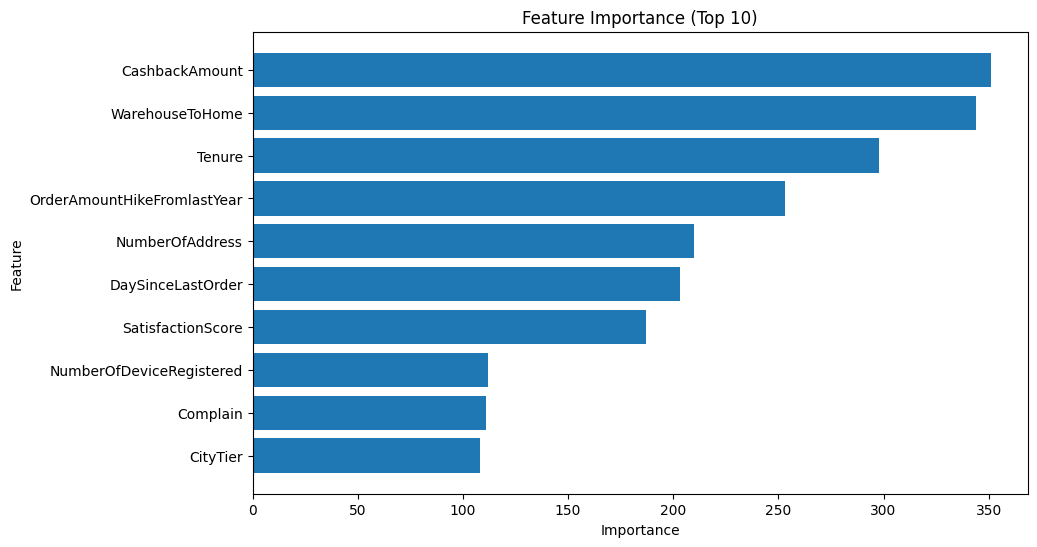


=== Top 10 Important Features ===
                        Feature  Importance
13               CashbackAmount         351
3               WarehouseToHome         344
1                        Tenure         298
9   OrderAmountHikeFromlastYear         253
7               NumberOfAddress         210
12            DaySinceLastOrder         203
6             SatisfactionScore         187
5      NumberOfDeviceRegistered         112
8                      Complain         111
2                      CityTier         108


In [4]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. 데이터 전처리
categorical_columns = data.select_dtypes(include=['object']).columns
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# 결측치 처리
data[categorical_columns] = data[categorical_columns].fillna('Unknown')
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# 타겟 변수와 독립 변수 설정
X = data.drop('Churn', axis=1)
y = data['Churn']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. LightGBM 모델 학습
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
)

# 3. 모델 평가
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

print("\n=== Model Performance ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# 4. ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='LightGBM (AUC = {:.2f})'.format(roc_auc_score(y_test, y_proba)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 5. Feature Importance 시각화
importance = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Top 10)')
plt.show()

# 상위 중요 Feature 출력
print("\n=== Top 10 Important Features ===")
print(importance_df.head(10))
